In [1]:
import numpy as np
import pandas as pd
import json
import os
import torch
import torch.nn.functional as F
from torch import Tensor, nn
from torch.utils.data import Dataset, DataLoader
from transformers import BartForConditionalGeneration, BartTokenizer, AdamW
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import nltk
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.meteor_score import meteor_score

nltk.download('punkt')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to /home/tobysavage/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/tobysavage/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Read in the Data

In [12]:
# Get the directory you want to list files from
directory = '../../data/LIGHT'

# List all files and directories in the specified directory
for filename in os.listdir(directory):
    if os.path.isfile(os.path.join(directory, filename)):
        print(filename)


train_light.json
ambignq_light.zip
ambig_disambig_dev.csv
ambig_disambig_train.csv
ambig_disambig_dev_full.csv
LICENSE
dev_light.json
ambig_disambig_dest.csv
ambig_disambig_test.csv


In [13]:
df_train = pd.read_csv('../../data/LIGHT/ambig_disambig_train.csv')
df_train.head()

,ambiguous_question,disambiguated_question
0,When did the simpsons first air on television?,When did the Simpsons first air on television ...
1,When did the simpsons first air on television?,When did the Simpsons first air as a half-hour...
2,What is the legal age of marriage in usa?,"What is the legal age of marriage, without par..."
3,What is the legal age of marriage in usa?,"What is the legal age of marriage, without par..."
4,What is the legal age of marriage in usa?,"What is the legal age of marriage, without par..."


In [14]:
df_dev = pd.read_csv('../../data/LIGHT/ambig_disambig_dev.csv')
df_dev.head()

,ambiguous_question,disambiguated_question
0,Who is the statue of liberty supposed to be?,Who is the statue of liberty in Leicester supp...
1,Who is the statue of liberty supposed to be?,Who is the statue of liberty in Seattle suppos...
2,Who conducted a 300 mile march to sacramento c...,Who is the individual that was the leader of a...
3,Who conducted a 300 mile march to sacramento c...,Who is the group that organized a strike and 3...
4,When was i'll be home for christmas released?,"When was the song ""I'll Be Home for Christmas""..."


In [15]:
df_test = pd.read_csv('../../data/LIGHT/ambig_disambig_test.csv')
df_test.head()

,ambiguous_question,disambiguated_question
0,Why did the st louis cardinals move to arizona?,What ability caused the st louis cardinals mov...
1,Why did the st louis cardinals move to arizona?,What physical issue caused the st louis cardin...
2,Why did the st louis cardinals move to arizona?,What fan issue caused the st louis cardinals m...
3,Who is the current chairman of african union c...,Who is the 4th chairman of african union commi...
4,Who is the current chairman of african union c...,Who is the 3rd chairman of african union commi...


In [16]:
df_dev_full = pd.read_csv('../../data/LIGHT/ambig_disambig_dev_full.csv')
df_dev_full.head()

,ambiguous_question,disambiguated_question
0,Why did the st louis cardinals move to arizona?,What ability caused the st louis cardinals mov...
1,Why did the st louis cardinals move to arizona?,What physical issue caused the st louis cardin...
2,Why did the st louis cardinals move to arizona?,What fan issue caused the st louis cardinals m...
3,Who is the current chairman of african union c...,Who is the 4th chairman of african union commi...
4,Who is the current chairman of african union c...,Who is the 3rd chairman of african union commi...


Model Set Up

In [17]:
# tokenizer = BartTokenizer.from_pretrained('facebook/bart-base')
tokenizer = BartTokenizer.from_pretrained('facebook/bart-large')
# Load pre-trained model
# model = BartForConditionalGeneration.from_pretrained('facebook/bart-base')
model = BartForConditionalGeneration.from_pretrained('facebook/bart-large')
model.config.dropout = 0.1

# move the model to the GPU
model.to('cuda')

BartForConditionalGeneration(
  (model): BartModel(
    (shared): Embedding(50265, 1024, padding_idx=1)
    (encoder): BartEncoder(
      (embed_tokens): Embedding(50265, 1024, padding_idx=1)
      (embed_positions): BartLearnedPositionalEmbedding(1026, 1024)
      (layers): ModuleList(
        (0-11): 12 x BartEncoderLayer(
          (self_attn): BartAttention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (fc2): Linear(in_features=4096, out_features=1024, bias=True)
          (final_layer_norm): LayerN

In [18]:
inputs_train = list(df_train['ambiguous_question'])
targets_train = list(df_train['disambiguated_question'])

# Tokenize inputs and targets
inputs_train = tokenizer(inputs_train, padding=True, truncation=True, return_tensors='pt')
targets_train = tokenizer(targets_train, padding=True, truncation=True, return_tensors='pt')

Convert Dataset to PyTorch Format

In [19]:
class AmbigNQDataset(Dataset):
    def __init__(self, encodings, resultings):
        self.encodings = encodings
        self.resultings = resultings
        
    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.resultings['input_ids'][idx]
        return item
    
    def __len__(self):
        return len(self.resultings['input_ids'])
    
dataset_train = AmbigNQDataset(inputs_train, targets_train)
loader_train = DataLoader(dataset_train, batch_size = 10, shuffle=True)

In [20]:
inputs_dev = list(df_dev['ambiguous_question'])
targets_dev = list(df_dev['disambiguated_question'])

# Tokenize inputs and targets
inputs_dev = tokenizer(inputs_dev, padding=True, truncation=True, return_tensors='pt')
targets_dev = tokenizer(targets_dev, padding=True, truncation=True, return_tensors='pt')
dataset_dev = AmbigNQDataset(inputs_dev, targets_dev)
loader_dev = DataLoader(dataset_dev, batch_size = 10, shuffle = True)

In [21]:
inputs_test = list(df_test['ambiguous_question'])
targets_test = list(df_test['disambiguated_question'])

# Tokenize inputs and targets
inputs_test = tokenizer(inputs_test, padding=True, truncation=True, return_tensors='pt')
targets_test = tokenizer(targets_test, padding=True, truncation=True, return_tensors='pt')
dataset_test = AmbigNQDataset(inputs_test, targets_test)
loader_test = DataLoader(dataset_test, batch_size = 10, shuffle = False)

In [22]:
inputs_dev_full = list(df_dev_full['ambiguous_question'])
targets_dev_full = list(df_dev_full['disambiguated_question'])

# Tokenize inputs and targets
inputs_dev_full = tokenizer(inputs_dev_full, padding=True, truncation=True, return_tensors='pt')
targets_dev_full = tokenizer(targets_dev_full, padding=True, truncation=True, return_tensors='pt')
dataset_dev_full = AmbigNQDataset(inputs_dev_full, targets_dev_full)
loader_dev_full = DataLoader(dataset_dev_full, batch_size = 10, shuffle = True)

Fine-Tuning BART-Large

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [24]:
print(device)
# print(torch.cuda.is_available())

cuda


In [ ]:
# load pre-trained BART-Large model for fine-tuning
epochs = 5
# model = BartForConditionalGeneration.from_pretrained('facebook/bart-large')

optimizer = AdamW(model.parameters(), lr=1e-5, eps=1e-8)

# Early Stopping Parameters
patience = 2
min_delta = 0.001
best_val_loss = np.inf
patience_counter = 0

training_losses = []
validation_losses = []

# training loop
model.train() # put model in train mode
for epoch in range(epochs):
    total_train_loss = 0
    for batch in loader_train:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to('cuda')
        attention_mask = batch['attention_mask'].to('cuda')
        resultings = batch['labels'].to('cuda')
        
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=resultings)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        
        total_train_loss +=loss.item()
        
    avg_train_loss = total_train_loss / len(loader_train)
    training_losses.append(avg_train_loss)
    print(f"Epoch: {epoch}, Training Loss: {avg_train_loss}")
    
    
    # Validation Step
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch in loader_dev:
            input_ids = batch['input_ids'].to('cuda')
            attention_mask = batch['attention_mask'].to('cuda')
            labels = batch['labels'].to('cuda')
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            
            total_val_loss += loss.item()
    avg_val_loss = total_val_loss/len(loader_dev)
    validation_losses.append(avg_val_loss)
    print(f"Epoch: {epoch}, Validation Loss: {avg_val_loss}")
    
    # Early Stopping Check
    if avg_val_loss + min_delta < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0  # reset counter if improvement is found
    else:
        patience_counter += 1  # increment counter if no improvement

    # Break the loop if patience is exceeded
    if patience_counter >= patience:
        print("Stopping early due to no improvement in validation loss.")
        break
    
    model.train()


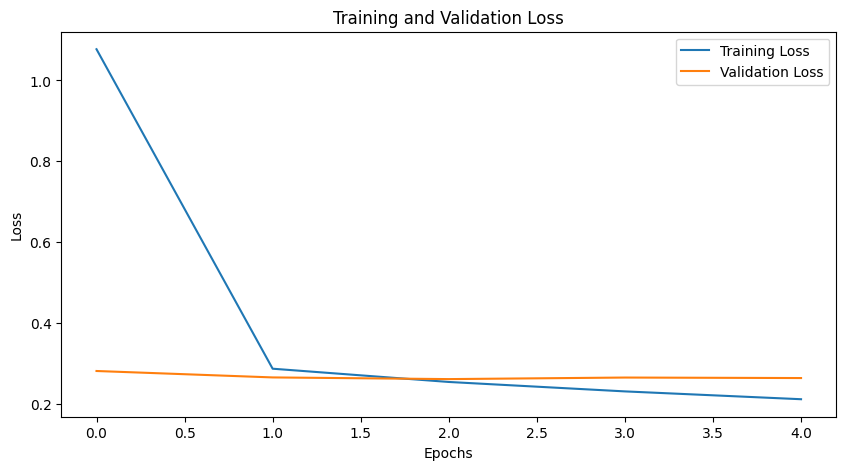

In [20]:
# cpu_training_loss = [loss_item.item() for loss_item in training_losses]

plt.figure(figsize=(10, 5))
plt.title("Training and Validation Loss")
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [22]:
model.eval()  # make sure the model is in evaluation mode
predictions = []
references = []

with torch.no_grad():
    for batch in loader_test:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        # Generate the outputs using the model
        outputs = model.generate(input_ids=input_ids, attention_mask=attention_mask)
        
        # Decode predictions
        pred_texts = tokenizer.batch_decode(outputs, skip_special_tokens=True)
        # print("BATCH: ", batch)
        # print("PREDS: ", pred_texts)
        predictions.extend(pred_texts)
        
        # Decode the reference labels
        ref_texts = tokenizer.batch_decode(batch['labels'], skip_special_tokens=True)
        # Here, we assume that each entry in the batch has only one reference
        
        input_texts = tokenizer.batch_decode(input_ids, skip_special_tokens=True)
        
        # for i in range(len(pred_texts)):  # Assuming batch size is not larger than the number of samples
        #     print(f"INPUT: {input_texts[i]}")
        #     print(f"ACTUAL: {ref_texts[i]}")
        #     print(f"PREDICTION: {pred_texts[i]}")
        #     print("\n")  # Adds a newline for better readability
        
        references.extend([[ref] for ref in ref_texts])
        # break

# Tokenize the predictions and references
tokenized_predictions = [nltk.word_tokenize(pred) for pred in predictions]
tokenized_references = [[nltk.word_tokenize(ref[0])] for ref in references]  # BLEU expects a list of references

# Calculate BLEU score
bleu_score = corpus_bleu(tokenized_references, tokenized_predictions)

# Calculate METEOR score
meteor_scores = [meteor_score([ref], pred) for ref, pred in zip(references, predictions)]
average_meteor_score = sum(meteor_scores) / len(meteor_scores)

print(f"Corpus BLEU Score on Test Set: {bleu_score}")
print(f"Average METEOR Score on Test Set: {average_meteor_score}")

TypeError: "hypothesis" expects pre-tokenized hypothesis (Iterable[str]): Why did the st louis cardinals move to arizona in 2016?

In [26]:
# cpu_training_loss = [loss_item.item() for loss_item in training_loss]

# plt.figure(figsize=(10, 5))
# plt.title("Training Loss")
# plt.plot(cpu_training_loss, label="Training")
# plt.xlabel("Iteration")
# plt.ylabel("Loss")

Save the Model

In [23]:
model.save_pretrained('pretrained_saves')
tokenizer.save_pretrained('pretrained_saves')

('pretrained_saves/tokenizer_config.json',
 'pretrained_saves/special_tokens_map.json',
 'pretrained_saves/vocab.json',
 'pretrained_saves/merges.txt',
 'pretrained_saves/added_tokens.json')

Load the Model

In [24]:
model = BartForConditionalGeneration.from_pretrained('pretrained_saves').to(device)

In [27]:
model.eval()  # make sure the model is in evaluation mode
predictions = []
references = []

with torch.no_grad():
    for batch in loader_test:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        # Generate the outputs using the model
        outputs = model.generate(input_ids=input_ids, attention_mask=attention_mask)
        
        # Decode predictions
        pred_texts = tokenizer.batch_decode(outputs, skip_special_tokens=True)
        # print(pred_texts)
        predictions.extend(pred_texts)
        
        # Decode the reference labels
        ref_texts = tokenizer.batch_decode(batch['labels'], skip_special_tokens=True)
        input_texts = tokenizer.batch_decode(input_ids, skip_special_tokens=True)
        
        for i in range(len(pred_texts)):  # Assuming batch size is not larger than the number of samples
            print(f"INPUT: {input_texts[i]}")
            print(f"ACTUAL: {ref_texts[i]}")
            print(f"PREDICTION: {pred_texts[i]}")
            print("\n")  # Adds a newline for better readability
        
        # Here, we assume that each entry in the batch has only one reference
        references.extend([[ref] for ref in ref_texts])
        # break


INPUT: Why did the st louis cardinals move to arizona?
ACTUAL: What ability caused the st louis cardinals move to arizona?
PREDICTION: Why did the st louis cardinals move to arizona in 2016?


INPUT: Why did the st louis cardinals move to arizona?
ACTUAL: What physical issue caused the st louis cardinals move to arizona?
PREDICTION: Why did the st louis cardinals move to arizona in 2016?


INPUT: Why did the st louis cardinals move to arizona?
ACTUAL: What fan issue caused the st louis cardinals move to arizona?
PREDICTION: Why did the st louis cardinals move to arizona in 2016?


INPUT: Who is the current chairman of african union commission?
ACTUAL: Who is the 4th chairman of african union commission?
PREDICTION: Who is the 12th chairman of african union commission?


INPUT: Who is the current chairman of african union commission?
ACTUAL: Who is the 3rd chairman of african union commission?
PREDICTION: Who is the 12th chairman of african union commission?


INPUT: Who is the current 

KeyboardInterrupt: 

In [26]:
# Tokenize the predictions and references
tokenized_predictions = [nltk.word_tokenize(pred) for pred in predictions]
tokenized_references = [[nltk.word_tokenize(ref[0])] for ref in references]  # BLEU expects a list of references

# Calculate BLEU score
bleu_score = corpus_bleu(tokenized_references, tokenized_predictions)

# Calculate METEOR score
meteor_scores = [meteor_score(refs, preds) for refs, preds in zip(tokenized_references, tokenized_predictions)]
average_meteor_score = sum(meteor_scores) / len(meteor_scores)

print(f"Corpus BLEU Score on Test Set: {bleu_score}")
print(f"Average METEOR Score on Test Set: {average_meteor_score}")

Corpus BLEU Score on Test Set: 0.4049434569729642
Average METEOR Score on Test Set: 0.6872554545833018


TODO: Only save model when dev_loss starts going up.